In [151]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cv2

import os

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle




In [152]:
%%capture
%run  letters_extraction.ipynb

In [153]:
directory = './symbols/'

<h3>Reading directory names</h3>

In [154]:
Name=[]
for file in os.listdir(directory):
    Name+=[file]
print(Name)
print(len(Name))

['0', '1', 'A', 'add', 'B', 'C', 'D', 'E', 'eq', 'F']
10


<h4>Getting a list of unique file extensions</h4>

In [155]:
extensions = []

for path, subdirs, files in os.walk(directory):
        for name in files:
            if os.path.splitext(name)[1] not in extensions:
                extensions += [os.path.splitext(name)[1]]

print(extensions)
sorted(os.listdir(directory))

['.png', '.jpg']


['0', '1', 'A', 'B', 'C', 'D', 'E', 'F', 'add', 'eq']

<h3>Map unique strings to integers in Python. Make dictionary</h3>

In [156]:
from collections import defaultdict
d = defaultdict(int)
co = 0
for x in sorted(os.listdir(directory)):
    if not d[x]:
        d[x] = co
        co+=1
d

defaultdict(int,
            {'0': 0,
             '1': 1,
             'A': 2,
             'B': 3,
             'C': 4,
             'D': 5,
             'E': 6,
             'F': 7,
             'add': 8,
             'eq': 9})

<h3>Resizing images</h3>

In [157]:
def prepare_image(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = get_letters(image, single_letter=True)[0]
    return image

def images_resize(directory):
    list_target_names = []
    list_images = []
        
    for path, subdirs, files in os.walk(directory):
        files = [f for f in files if not f[0] == '.'] # Ignore '.directory' file
        subdirs[:] = [d for d in subdirs if not d[0] == '.'] # Ignore hidden directories
        
        for name in files:
            image=cv2.imread(os.path.join(path, name))
            image = prepare_image(image)
            # image=cv2.resize(image, (100, 100))
            list_target_names.append(os.path.basename(path))
            list_images.append(image)
    
    return list_target_names,  list_images 
        
target_names,images = images_resize(directory)

In [158]:
len(target_names)

2716

In [159]:
len(images)

2716

In [160]:
from collections import Counter
c = Counter(sorted(target_names))

c

Counter({'0': 595,
         '1': 562,
         'A': 55,
         'B': 55,
         'C': 55,
         'D': 55,
         'E': 54,
         'F': 55,
         'add': 596,
         'eq': 634})

<h3>Assign a Dictionary Value to the List <B><I>"target_names"</I></B> Based on Dictionary Key</h3>

In [161]:
target_names = [d[key] for key in target_names]

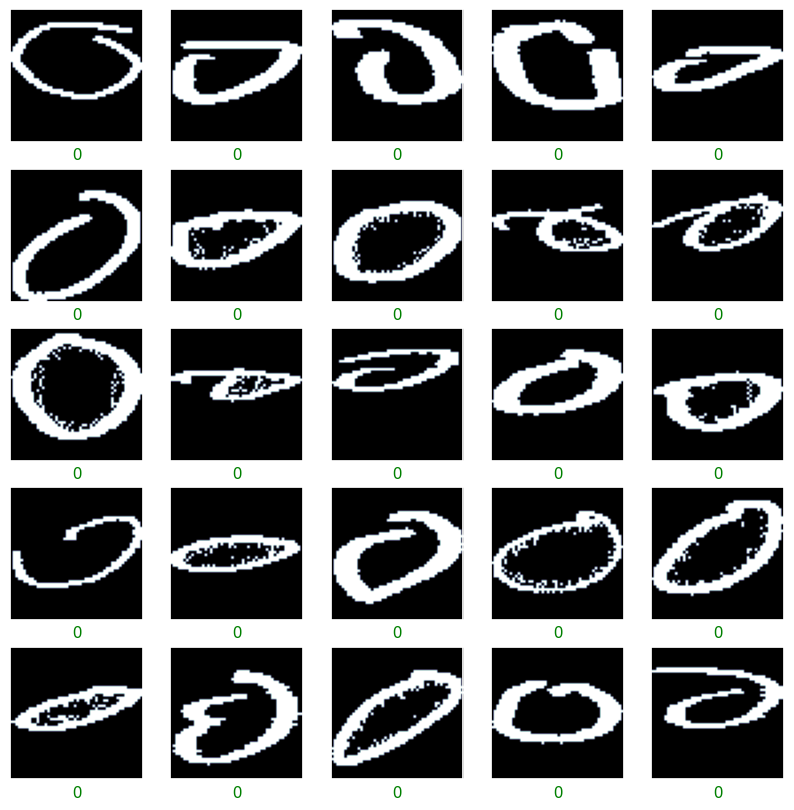

In [162]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=target_names[i])
    axi.xaxis.label.set_color('green')

<h4>Randomly shuffle two lists "target_names" and "images" keeping initial order</h4>

In [163]:
# target_names_shuffled, images_shuffled = shuffle(np.array(target_names, dtype=object), np.array(images, dtype=object))
target_names_shuffled, images_shuffled = shuffle(np.array(target_names), np.array(images))

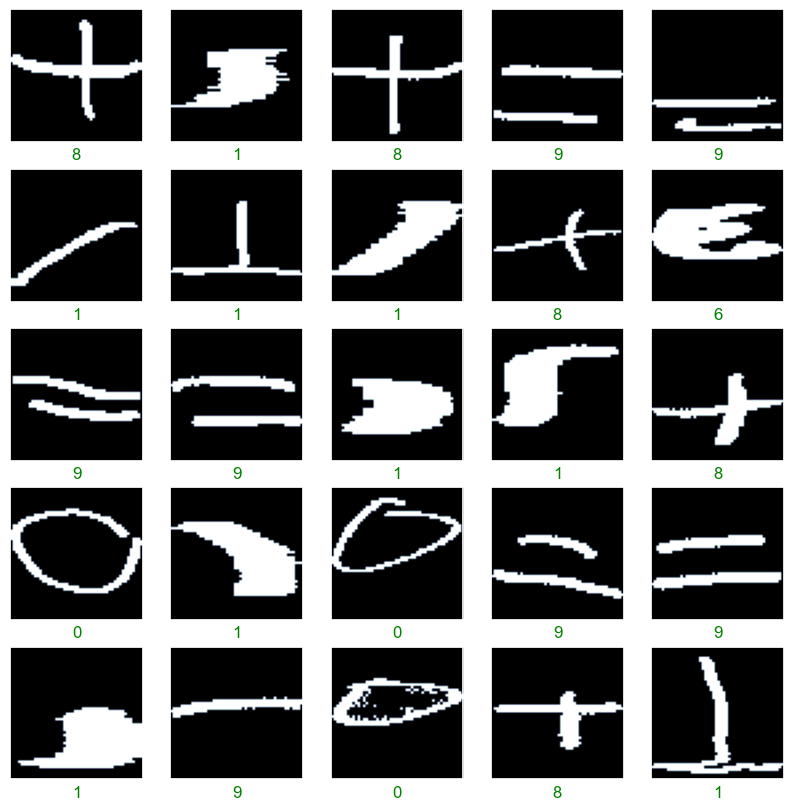

In [164]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(images_shuffled[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=target_names_shuffled[i])
    axi.xaxis.label.set_color('green')

<h4>Reshaping dataframe</h4>

In [165]:
n_samples,nx,ny= images_shuffled.shape
images_shuffled = images_shuffled.reshape(n_samples, nx*ny)
images_shuffled.shape

(2716, 2500)

In [166]:
Xtrain, Xtest, ytrain, ytest = train_test_split(images_shuffled, target_names_shuffled, random_state=0)

<h3>Implementing an Random Forest Classifier</h3>

In [167]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)


# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier()
# clf.fit(Xtrain, ytrain)
# ypred = clf.predict(Xtest)

# from sklearn import svm
# model = svm.SVC(gamma = 0.001, C =100)
# model.fit(Xtrain, ytrain)
# ypred = model.predict(Xtest)

<h3>The classification report for this classifier:</h3>

In [168]:
from sklearn import metrics
print(Xtest.shape)
print(metrics.classification_report(ytest, ypred))
print("Accuracy:",metrics.accuracy_score(ytest, ypred))

(679, 2500)
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       161
           1       0.95      0.89      0.92       149
           2       1.00      0.93      0.96        14
           3       0.90      0.64      0.75        14
           4       0.80      0.89      0.84         9
           5       1.00      0.42      0.59        12
           6       1.00      0.57      0.73        14
           7       0.85      1.00      0.92        11
           8       0.90      0.94      0.92       121
           9       0.93      0.99      0.96       174

    accuracy                           0.93       679
   macro avg       0.93      0.82      0.85       679
weighted avg       0.93      0.93      0.92       679

Accuracy: 0.9278350515463918


<h3>Plot the confusion matrix:</h3>

Text(273.99999999999994, 0.5, 'predicted label')

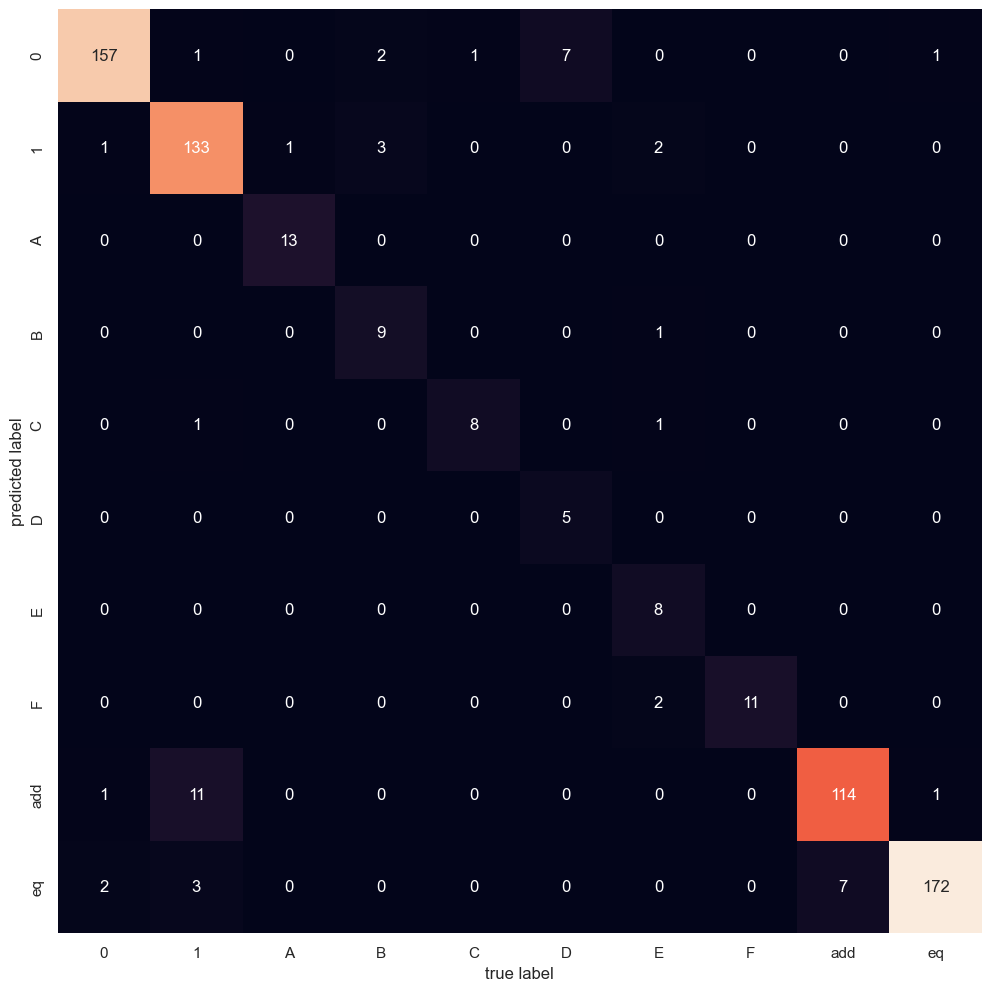

In [169]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,12)})

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=list(d.keys()), yticklabels=list(d.keys()))


plt.xlabel('true label')
plt.ylabel('predicted label')


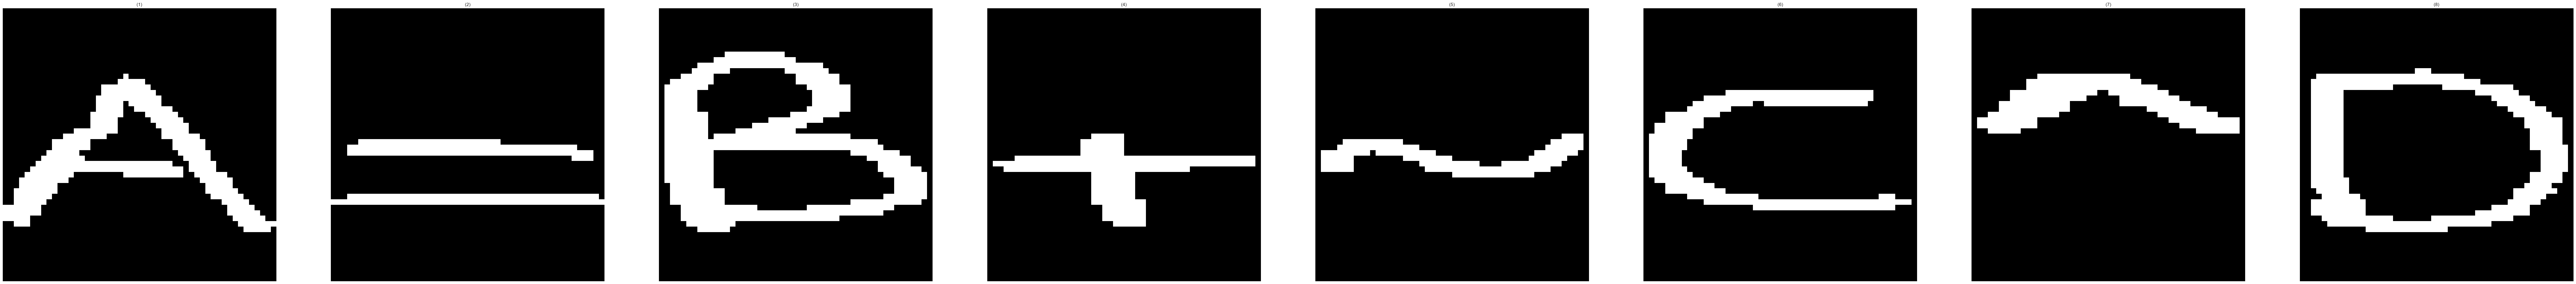

(8, 2500)
[2 9 3 8 8 4 9 0]
['A', 'eq', 'B', 'add', 'add', 'C', 'eq', '0']
['A', 'eq', 'B', 'add', 'add', 'C', 'eq', '0']


In [170]:
letters= cv2.cvtColor(cv2.imread(r'D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\test_images\2.png'), cv2.COLOR_BGR2GRAY)
letters_res = np.array(get_letters(letters, single_letter=False))
cf.show_images(letters_res)
# cf.show_images([letters_res[0], get_letters(letters, single_letter=False)[0]])

letters_res = letters_res.reshape(len(letters_res), -1)

print(letters_res.shape)

results = model.predict(letters_res)
print(results)
print([list(d.keys())[i] for i in results])
inv_map = {v: k for k, v in d.items()}
print([inv_map[i] for i in results])


In [171]:
# letters= cv2.cvtColor(cv2.imread(r'D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\datasets\symbol2\9\0ZGdgPTM.png'), cv2.COLOR_BGR2GRAY)
# letters_res = np.array(get_letters(letters, single_letter=True, show_trace=True))
# cf.show_images([letters_res[0], get_letters(letters, single_letter=False,show_trace=True)[0]])